In [29]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [7]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

df = pd.read_excel("dollar.xlsx")
df = df.rename(columns={"курс доллара": "cost"})
dataset = df[['data','cost']].set_index('data')

# dataset = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "cost")
dataset

,cost
data,
2018-02-13,45.3520
2018-02-14,45.4535
2018-02-15,45.3175
2018-02-16,45.0810
2018-02-17,44.9885
...,...
2019-02-07,46.8414
2019-02-08,46.8609
2019-02-09,46.8385


# Скользящее среднее

In [8]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.cost, 24)

47.439075

In [9]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(dataset[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

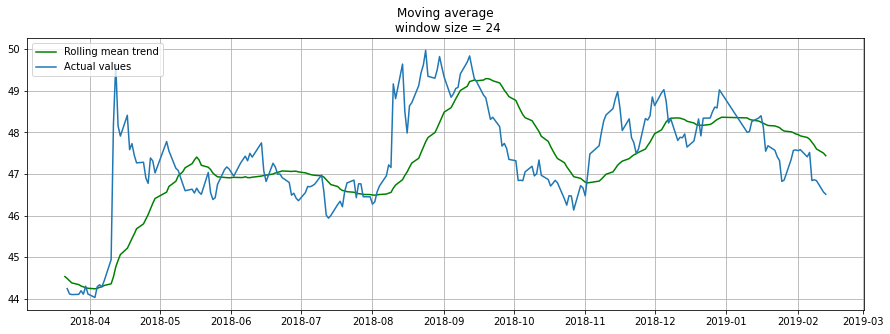

In [11]:
plotMovingAverage(dataset, 24) # сглаживаем по дням


# Взвешенное среднее

In [13]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(dataset.cost, [0.6, 0.2, 0.1, 0.07, 0.03])

46.815933

# Экспоненциальное сглаживание

In [14]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

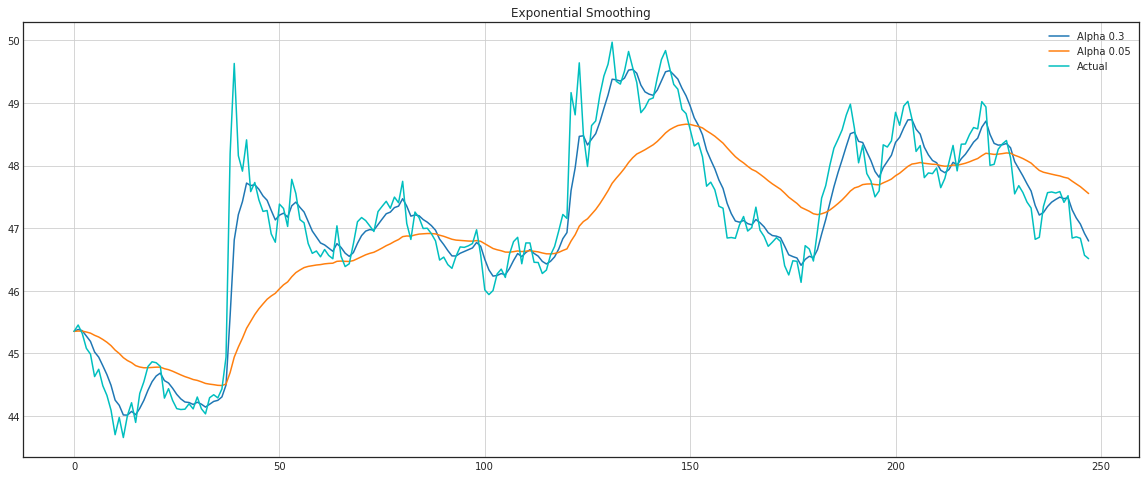

In [15]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.cost, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.cost.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

# Двойное экспоненциальное сглаживание.

In [16]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

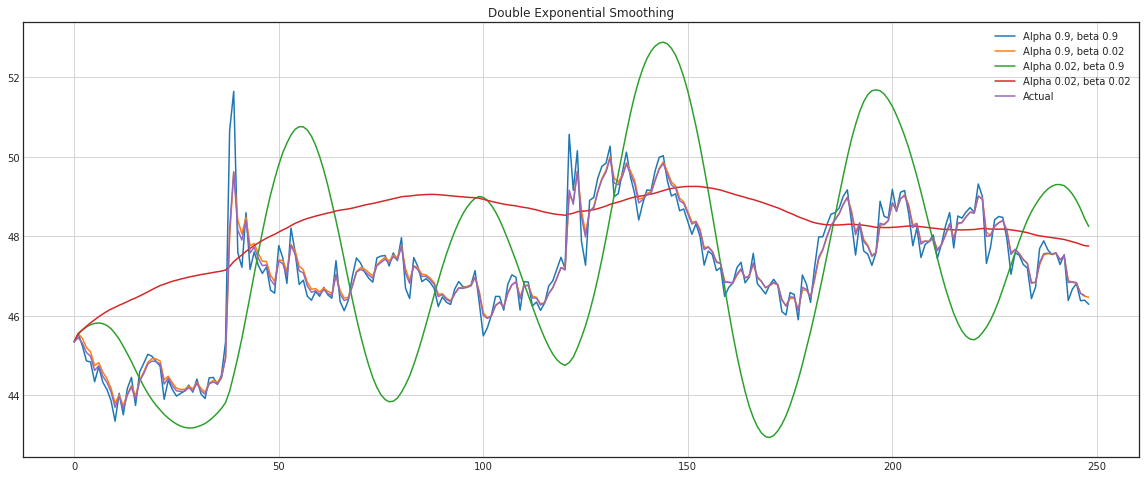

In [18]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.cost, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.cost.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

## Избавляемся от нестационарности

Критерий Дики-Фуллера: p=0.161983


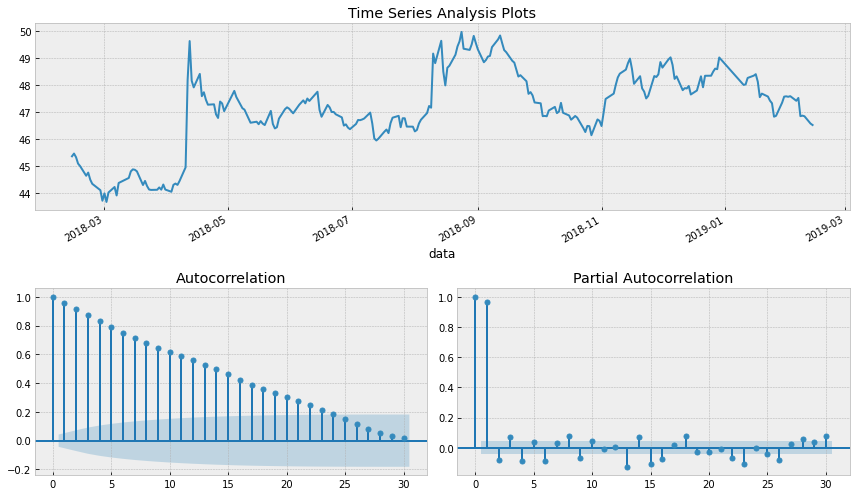

In [19]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dataset.cost, lags=30)

Критерий Дики-Фуллера: p=0.106554
Оптимальный параметр преобразования Бокса-Кокса: 7.132564


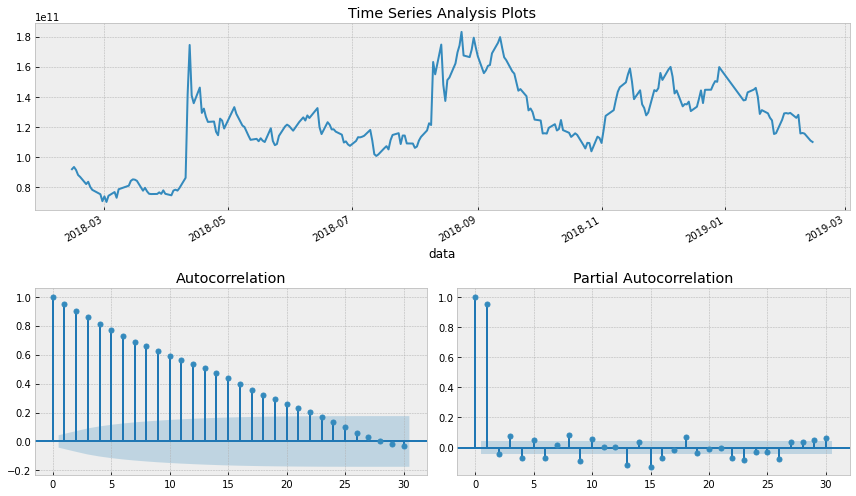

In [23]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = dataset.copy()
data['cost_box'], lmbda = scs.boxcox(data.cost)
tsplot(data.cost_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.044801


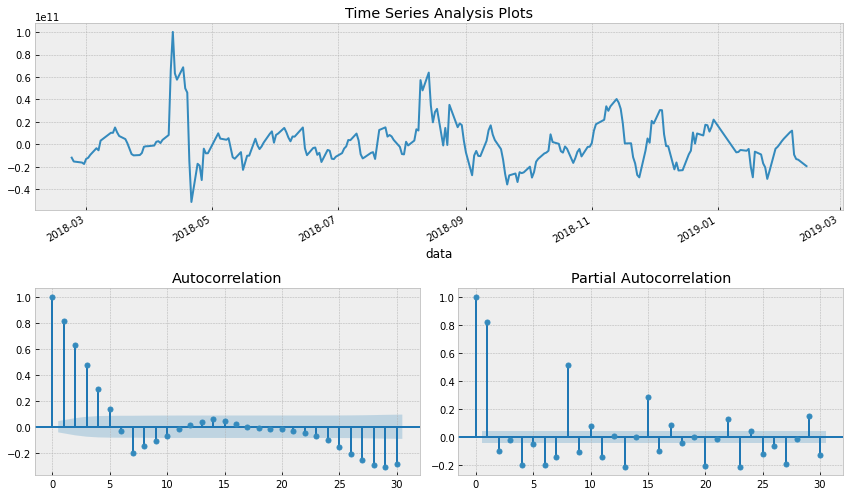

In [39]:
data['cost_box_season'] = data.cost_box - data.cost_box.shift(7)
tsplot(data.cost_box_season[7:], lags=30)

Критерий Дики-Фуллера: p=0.000000


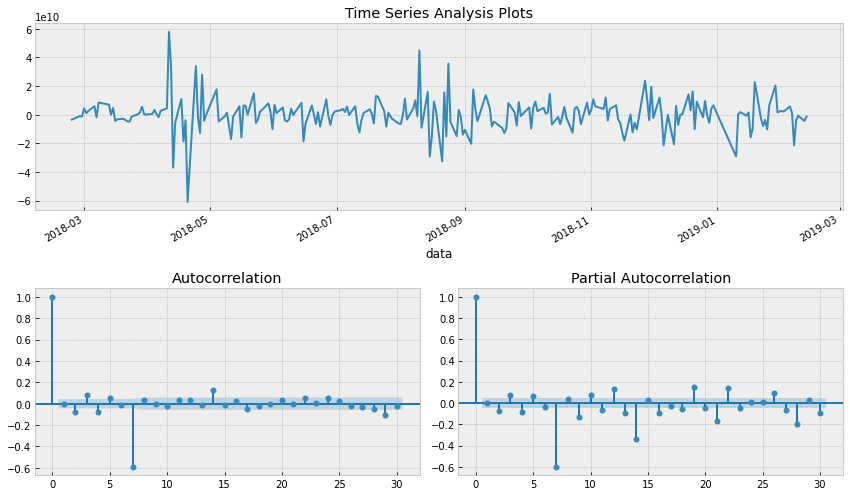

In [40]:
data['cost_box_season_diff'] = data.cost_box_season - data.cost_box_season.shift(1)
tsplot(data.cost_box_season_diff[7+1:], lags=30)

#ARMA

## SARIMA

In [36]:
ps = range(1,3) #range(0, 5)
d=1
qs = range(1,3) #range(0, 4)


Ps = range(1,3) #range(0, 5)
D=1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
parameters_list

[(1, 1, 1, 0),
 (1, 1, 2, 0),
 (1, 2, 1, 0),
 (1, 2, 2, 0),
 (2, 1, 1, 0),
 (2, 1, 2, 0),
 (2, 2, 1, 0),
 (2, 2, 2, 0)]

In [41]:
%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.cost_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3],7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

100%|██████████| 8/8 [00:07<00:00,  1.03it/s]

     parameters           aic
1  (1, 1, 2, 0)  11740.268391
5  (2, 1, 2, 0)  11740.559675
7  (2, 2, 2, 0)  11742.791239
3  (1, 2, 2, 0)  11743.537547
4  (2, 1, 1, 0)  11755.289927
CPU times: user 11.4 s, sys: 1.53 s, total: 12.9 s
Wall time: 7.83 s


In [47]:
%%time
best_model = sm.tsa.statespace.SARIMAX(data.cost_box, order=(1, d, 1), 
                                        seasonal_order=(2, D, 0, 7)).fit(disp=-1)
print(best_model.summary())  

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                                     SARIMAX Results                                      
Dep. Variable:                           cost_box   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 7)   Log Likelihood               -5865.134
Date:                            Thu, 17 Jun 2021   AIC                          11740.268
Time:                                    22:49:31   BIC                          11757.672
Sample:                                         0   HQIC                         11747.281
                                            - 248                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6435      0.563     -1.143      0.253      -1.747       0.460
ma.L1          0.7154      0.523   

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Критерий Дики-Фуллера: p=0.000000


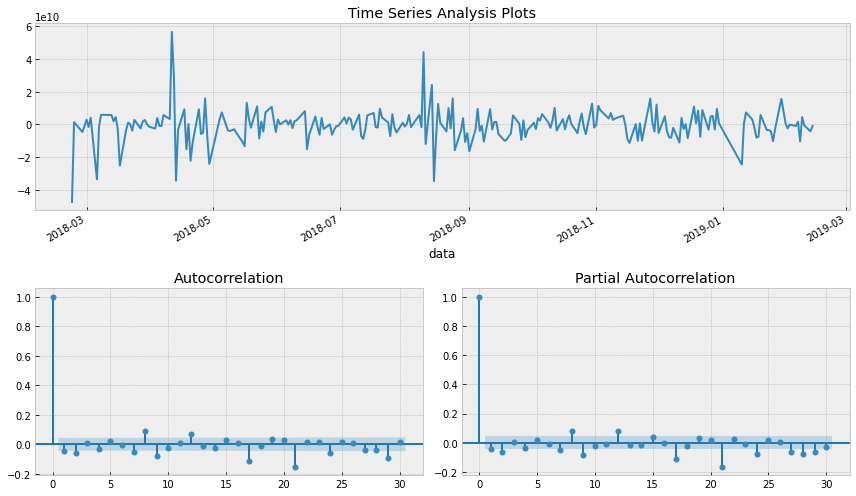

In [48]:
tsplot(best_model.resid[7:], lags=30)

## Строим прогноз

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:380: DeprecationWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



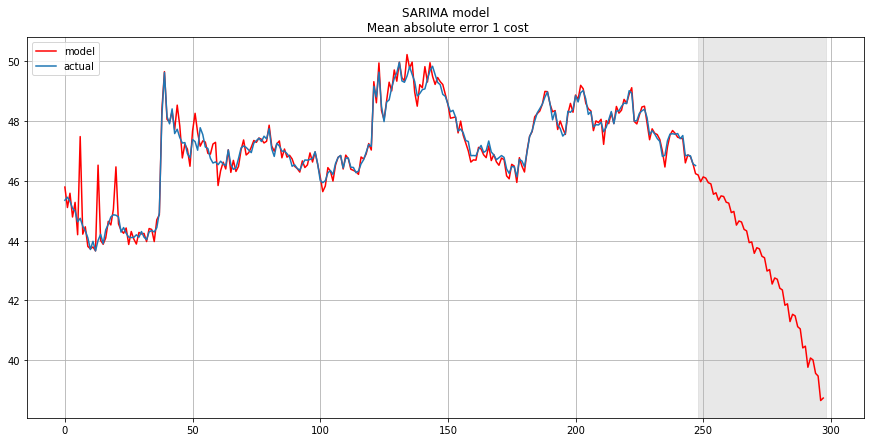

In [80]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+50), lmbda)
forecast = data.arima_model.append(forecast).values[-298:]
actual = data.cost.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} cost".format(round(mean_absolute_error(data.cost, data.arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)